In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import os
from datetime import datetime
import random
import string
import multiprocessing as mp
import itertools

In [2]:
import matplotlib.pyplot as plt
import timeit
%load_ext memory_profiler


In [3]:
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

In [4]:
REWARD = 100

In [5]:
seed = 9295
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

env = gym.make('CartPole-v0')
XTRA_FEAT   = 1 #pole length
N_ACTIONS   = env.action_space.n
N_STATES    = env.observation_space.shape[0]  +  XTRA_FEAT 
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape     # to confirm the shape

In [6]:
RNDM_STRING = ''.join(random.choices(string.ascii_uppercase + string.digits, k=8)) + datetime.now().strftime("_%H_%M_%S")
print("ID: ",RNDM_STRING)
MODEL_FILENAME = './models/'+ RNDM_STRING + "_NN" + ".pt"
print("NN-MODEL FILENAME: ", MODEL_FILENAME)

ID:  VBKG0BIX_01_47_43
NN-MODEL FILENAME:  ./models/VBKG0BIX_01_47_43_NN.pt


In [7]:
def ndim_grid(start,stop, granularity):
    # Set number of dimensions
    ndims = len(start)

    # List of ranges across all dimensions
    L = [np.linspace(start[i],stop[i],granularity[i]) for i in range(ndims)]

    # Finally use meshgrid to form all combinations corresponding to all 
    # dimensions and stack them as M x ndims array
    return np.hstack((np.meshgrid(*L))).swapaxes(0,1).reshape(ndims,-1).T

In [8]:
def discretize(value, borders):
    c_pos_val, c_vel_val, p_ang_val, p_vel_val, length_val   = value
    c_pos_s  , c_vel_s  ,p_ang_s   , p_vel_s  , length_s     = borders
    
    indx = np.empty_like(value).astype(np.uint)
    
    for i in range(value.shape[0]):
        if value[i] > borders[i].max():
            indx[i] = borders[i].argmax()
        else:
            indx[i] = np.where(borders[i] >= value[i])[0][0].astype(np.uint)
    return indx



In [9]:
T_LR           = 1e-2
T_GAMMA        = 0.99
T_EPSILON      = 0.98

NO_OF_NODES    = 10
NO_OF_EPISODES = 100
TIMESTEP_LIMIT = 200

print("Number of NODES: ", NO_OF_NODES)
print("Number of EPISODES per NODE", NO_OF_EPISODES)

Number of NODES:  10
Number of EPISODES per NODE 100


In [10]:
# Hyper Parameters
HIDDEN_LAYER        = 50
BATCH_SIZE          = 32
NN_LR               = 1e-3  # learning rate
NN_GAMMA            = 0.9   # reward discount
TARGET_REPLACE_ITER = 500   # target update frequency
MIN_MEMORY_CAP      = 200000

In [11]:
MAX_NO_OF_ITERATIONS = 50
MAX_NN_ITERATIONS    = 50000
print("Number of ITERATIONS: ",MAX_NO_OF_ITERATIONS)

Number of ITERATIONS:  50


In [12]:
# class Net(nn.Module):
#     def __init__(self, ):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(N_STATES, 50)
#         nn.init.kaiming_uniform_(self.fc1.weight)   # initialization
#         self.out = nn.Linear(50, N_ACTIONS)
#         nn.init.xavier_uniform_(self.out.weight)   # initialization

#     def forward(self, x):
#         x = self.fc1(x)
#         x = F.relu(x)
#         actions_value = self.out(x)
#         return actions_value

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(N_STATES, HIDDEN_LAYER)
        nn.init.kaiming_uniform_(self.fc1.weight)

        self.adv = nn.Linear(HIDDEN_LAYER, N_ACTIONS)
        nn.init.xavier_uniform_(self.adv.weight) 
    
        self.val = nn.Linear(HIDDEN_LAYER, 1)
        nn.init.xavier_uniform_(self.val.weight)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)

        adv = self.adv(x)
        val = self.val(x)
        
        return val + adv - adv.mean()
    
class D3QN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()

        self.learn_step_counter  = 0 # for target updating
        
        self.memory_counter      = 0
        self.memory              = np.zeros((int(MIN_MEMORY_CAP), N_STATES * 2 + 2)) # initialize memory
        
#         self.good_memory_counter = 0 # for storing non-terminal memories
#         self.good_memory         = np.zeros((MIN_MEMORY_CAP ,N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
#         self.bad_memory_counter  = 0 # for storing terminal memories
#         self.bad_memory          = np.zeros((MIN_MEMORY_CAP , N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        self.running_loss        = 0
        self.optimizer           = torch.optim.Adam(self.eval_net.parameters(), lr=NN_LR)
        self.loss_func           = nn.MSELoss()

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)
        return action
    
    def choose_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions_value = self.eval_net.forward(x)
        action = torch.max(actions_value, 1)[1].data.numpy()
        action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return action
    
    def get_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions = self.eval_net.forward(x).view(-1,N_ACTIONS).max(1)[1].data.numpy().astype(np.intp)
#         actions_value 
#         action = torch.max(actions_value, 1)[1].data.numpy()
#         action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return actions
    
    def get_qvals(self,x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        actions_value = self.eval_net.forward(x)
        actions_value = actions_value.data.numpy().astype(np.float16)
        return actions_value

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1
        
        sample_index_limit = min(MIN_MEMORY_CAP, self.memory_counter)
        sample_index = np.random.choice(int(sample_index_limit),int(BATCH_SIZE))
        b_memory = self.memory[sample_index,:]
#         # sample batch transitions
#         good_sample_index_limit = min(MIN_MEMORY_CAP, self.good_memory_counter)
#         bad_sample_index_limit = min(MIN_MEMORY_CAP, self.bad_memory_counter)

#         good_sample_index = np.random.choice(int(good_sample_index_limit), int(BATCH_SIZE-int(BATCH_SIZE*TERMINAL_BIAS)))
#         bad_sample_index  = np.random.choice(int(bad_sample_index_limit),  int(BATCH_SIZE*TERMINAL_BIAS))

#         b_good_memory = self.good_memory[good_sample_index, :]
#         b_bad_memory  = self.bad_memory[bad_sample_index, :]
#         b_memory      = np.vstack((b_good_memory,b_bad_memory))
        
        b_s  = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a  = torch.LongTensor( b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r  = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        # q_eval w.r.t the action in experience
        q_eval   = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        a_eval   = self.eval_net(b_s).max(1)[1].view(BATCH_SIZE, 1) #best action according to eval_net
        q_next   = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + NN_GAMMA * q_next.gather(1, a_eval)   # shape (batch, 1)
        loss     = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.running_loss += loss.mean().item()
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            print('LOSS : %.3f' %(self.running_loss / TARGET_REPLACE_ITER), end="\t")
            self.running_loss = 0.0

In [13]:
def clamp(MIN_VAL, VAL, MAX_VAL):
    return max(MIN_VAL, min(VAL, MAX_VAL))

In [14]:
# ABSOLUTE LIMITS ON STATE VALUES
C_POS_ABS_MAX =  2.6
C_POS_ABS_MIN = -2.6

C_VEL_ABS_MAX =  5
C_VEL_ABS_MIN = -5

P_ANG_ABS_MAX =  0.25
P_ANG_ABS_MIN = -0.25

P_VEL_ABS_MAX =  6
P_VEL_ABS_MIN = -6

LENGTH_ABS_MAX = 0.725
LENGTH_ABS_MIN = 0.275

In [15]:
# SET GRANULARITY
HI_GRAIN = 40
LO_GRAIN = 1
print("HI_GRAIN = ", HI_GRAIN)
print("LO_GRAIN = ", LO_GRAIN)

HI_GRAIN =  40
LO_GRAIN =  1


In [16]:
def mp_node_run(node_id, boundary, iteration, node_q_table):

    # SET SEED
    ###############################################
    my_seed = seed + node_id + iteration
    random.seed(my_seed)
    torch.manual_seed(my_seed)
    np.random.seed(my_seed)
    os.environ['PYTHONHASHSEED'] = str(my_seed)
    my_env = env
    my_env.seed(my_seed)
    ###############################################
     # Mean values of pole length deviate from original value
    scaling_factor = 0.4 + (1.4 - 0.4) * (node_id + 1)/(NO_OF_NODES)
    ORIGNAL_LENGTH = 0.5    
    length_mean    = ORIGNAL_LENGTH * scaling_factor

    LENGTH_MAX = length_mean + 0.025
    LENGTH_MIN = length_mean - 0.025

    # CREATE STATE TABLE BORDERS
    ###############################################
    c_pos_s  = np.linspace(C_POS_ABS_MIN,  C_POS_ABS_MAX,  HI_GRAIN)
    c_vel_s  = np.linspace(C_VEL_ABS_MIN,  C_VEL_ABS_MAX,  HI_GRAIN)
    p_ang_s  = np.linspace(P_ANG_ABS_MIN,  P_ANG_ABS_MAX,  HI_GRAIN)
    p_vel_s  = np.linspace(P_VEL_ABS_MIN,  P_VEL_ABS_MAX,  HI_GRAIN)
    length_s = np.linspace(LENGTH_MIN,     LENGTH_MAX,     LO_GRAIN)

    borders = [c_pos_s, c_vel_s, p_ang_s, p_vel_s, length_s]
    ###############################################
    
    my_Q_TABLE = node_q_table[:,:,:,:, int(node_id*LO_GRAIN):int((node_id+1)*LO_GRAIN)]

    time_rec                = np.zeros(NO_OF_EPISODES)
    level_up_flag           = False
    PERFECT_RUN_COUNTER     = 10
    PERFECT_RUNS_HIGH_SCORE = 10
    level_up_metric         = 195

    exp_rec      = np.empty(N_STATES * 2 + 2)
    
#     if iteration < 3:
    my_EPSILON   = np.clip(((3%5 + 1)*0.1 + (iteration)*0.2) ,0.4,0.98)+ np.random.uniform(-0.01,0.01)
#     print(node_id, my_EPSILON)
#     else:
#         my_EPSILON   = T_EPSILON + np.random.uniform(-0.01,0.01)
    
    while True:
        i_episode = 0
        
        while i_episode < NO_OF_EPISODES:
            ep_exp_rec = np.empty(N_STATES * 2 + 2)
            time_steps = 0
            
            my_env.length   = length_mean + np.random.uniform(-0.025,0.025)
            xtra = [my_env.length]
            
            s = my_env.reset()
            s = np.append(s, xtra)
            while True:
                time_steps += 1
                
                #get state
                this_state = tuple(discretize(s, borders))
                
                # choose action
                if np.random.uniform() > my_EPSILON:   # greedy
                    a = np.random.randint(0, N_ACTIONS)
                else:
                    a = my_Q_TABLE[this_state]

                 # take action
                s_, r, done, info = my_env.step(a)
                s_ = np.append(s_, xtra)

                if done:
                    r = -REWARD
                    if time_steps >= TIMESTEP_LIMIT:
                        r = REWARD
                
                #store experience
                experience = np.hstack((s,a,r,s_))
                exp_rec = np.vstack((exp_rec, experience))

                #discretize next_state
                next_state = tuple(discretize(s_, borders))
                
                if done or time_steps >= TIMESTEP_LIMIT:
                    time_rec[i_episode] = time_steps
                    break
                s = s_

            i_episode += 1
        if i_episode >= NO_OF_EPISODES:
            i_episode = 0
            break

    exp_rec = np.delete(exp_rec, 0, 0)
#         message = "NODE#"+str(node_id) +" MAIN Q:"+ str(new_Q_TABLE.mean()) +"\t" + "NODE Q:" + str(my_Q_TABLE.mean())
#         print(message)
    
    # GET NEW STATE BOUNDARIES: +/- 25% of experienced state
    [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX ] = [exp_rec[:,i].max() for i in range(N_STATES)]
    [C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN ] = [exp_rec[:,i].min() for i in range(N_STATES)]

    newboundary = [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
                   C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]
    
    return exp_rec, time_rec, newboundary

In [17]:
total_serial_timesteps   = 0
total_parallel_timesteps = 0

In [18]:
iteration = 0
# my_dqn = D3QN()
dqn = D3QN()

# INITIALIZE BOUNDARY TO MAXIMUM VALUES
init_node_boundary = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX,
                      C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN]



# CREATE STATE COMBINATIONS
# ###############################################

init_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
                                    [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
                                    [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN*NO_OF_NODES   ])



# # GET Q-VALUES 
start = timeit.default_timer()
%memit init_q_table = dqn.get_greedy_action(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN,LO_GRAIN*NO_OF_NODES).astype(np.intp)
stop = timeit.default_timer()
print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    
# SAVE QFILE
# node_QFILE = './Q_NPY/' + RNDM_STRING + 'QFILE' + ".npy"
# np.save(node_QFILE, init_q_table)

peak memory: 11814.29 MiB, increment: 10695.71 MiB
Quantization TIME:  0.11 minutes


In [19]:
# ENVIRONMENT FOR CHECKING NN MODEL
v_env = gym.make('CartPole-v0')
v_env.seed(seed*2)

# CREATE A POOL OF PROCESSES
pool = mp.Pool(NO_OF_NODES)

# SET INITIAL NODE BOUDNARIES FOR ALL NODES
node_boundaries = [init_node_boundary] * NO_OF_NODES
node_q_table = init_q_table



ITERATION # 0
TOTAL EXPERIENCE GENERATED:   40519
SMALLEST TIMESTEP: 8
LARGEST  TIMESTEP: 148
TOTAL SERIAL TIMESTEPS:   40519
TOTAL PARALLEL TIMESTEPS: 148


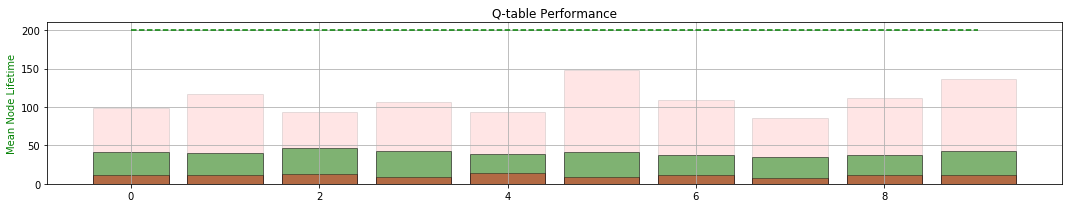

MEMORY COUNTER:  40519
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 222.486	LOSS : 237.074	LOSS : 235.459	LOSS : 235.458	LOSS : 235.032	LOSS : 236.557	LOSS : 224.923	LOSS : 227.616	LOSS : 231.738	LOSS : 213.613	LOSS : 227.126	LOSS : 231.562	LOSS : 231.295	LOSS : 238.174	LOSS : 227.366	LOSS : 217.479	LOSS : 207.488	LOSS : 205.696	LOSS : 214.107	LOSS : 210.072	
Validating... MEAN TIME:  200.0
LOSS : 210.228	LOSS : 224.234	LOSS : 205.439	LOSS : 218.996	LOSS : 212.177	LOSS : 207.879	LOSS : 213.788	LOSS : 212.040	LOSS : 205.827	LOSS : 210.643	LOSS : 223.664	LOSS : 206.673	LOSS : 202.395	LOSS : 207.906	LOSS : 213.435	LOSS : 204.616	LOSS : 205.562	LOSS : 213.996	LOSS : 214.559	LOSS : 213.514	
Validating... MEAN TIME:  194.32
LOSS : 213.552	LOSS : 206.907	LOSS : 211.527	LOSS : 211.085	LOSS : 223.825	LOSS : 211.706	LOSS : 200.813	LOSS : 206.819	LOSS : 212.831	LOSS : 198.739	LOSS : 197.726	LOSS : 205.437	LOSS : 198.825	LOSS : 211.830	LOSS : 205.316	LOSS : 214.298	LOSS : 210.

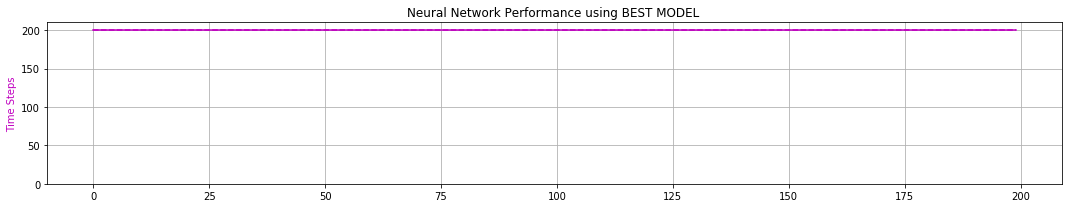

peak memory: 12049.11 MiB, increment: 10692.32 MiB
0 -max- [ 1.000  2.411  0.209  2.004  0.274]
0 -min- [-0.681 -1.406 -0.209 -2.286  0.226]

1 -max- [ 0.860  2.086  0.208  1.939  0.325]
1 -min- [-0.455 -1.321 -0.209 -2.221  0.275]

2 -max- [ 1.533  2.831  0.208  1.867  0.375]
2 -min- [-0.393 -1.172 -0.209 -2.260  0.327]

3 -max- [ 1.066  2.236  0.209  1.704  0.425]
3 -min- [-1.046 -1.868 -0.209 -1.962  0.375]

4 -max- [ 0.886  2.244  0.209  1.678  0.474]
4 -min- [-0.474 -1.482 -0.209 -2.332  0.425]

5 -max- [ 1.212  2.394  0.209  2.127  0.525]
5 -min- [-1.345 -1.685 -0.209 -2.393  0.476]

6 -max- [ 1.004  2.042  0.209  1.835  0.575]
6 -min- [-1.307 -1.829 -0.209 -2.222  0.525]

7 -max- [ 0.878  2.048  0.209  2.026  0.625]
7 -min- [-0.475 -1.765 -0.209 -2.194  0.577]

8 -max- [ 0.664  1.747  0.209  2.231  0.675]
8 -min- [-0.367 -1.880 -0.209 -2.176  0.626]

9 -max- [ 1.854  2.643  0.208  1.968  0.724]
9 -min- [-0.627 -1.865 -0.209 -2.238  0.676]

Quantization TIME:  0.11 minutes


ITER

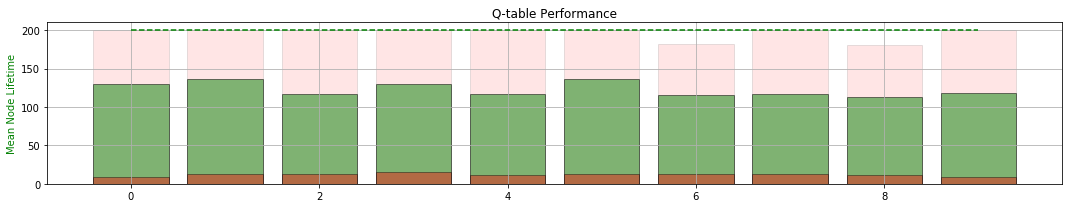

MEMORY COUNTER:  163424
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 134.442	LOSS : 124.930	LOSS : 123.453	LOSS : 115.325	LOSS : 115.990	LOSS : 121.509	LOSS : 116.966	LOSS : 120.950	LOSS : 115.709	LOSS : 106.716	LOSS : 122.155	LOSS : 112.856	LOSS : 119.291	LOSS : 106.619	LOSS : 111.073	LOSS : 112.831	LOSS : 108.120	LOSS : 118.992	LOSS : 120.495	LOSS : 99.980	
Validating... MEAN TIME:  155.025
LOSS : 117.504	LOSS : 115.066	LOSS : 101.897	LOSS : 107.607	LOSS : 108.478	LOSS : 118.389	LOSS : 120.115	LOSS : 115.849	LOSS : 111.591	LOSS : 122.362	LOSS : 115.915	LOSS : 111.260	LOSS : 110.281	LOSS : 121.663	LOSS : 112.644	LOSS : 113.800	LOSS : 111.037	LOSS : 120.707	LOSS : 111.869	LOSS : 109.713	
Validating... MEAN TIME:  153.85
LOSS : 111.025	LOSS : 113.697	LOSS : 108.527	LOSS : 104.472	LOSS : 108.582	LOSS : 118.267	LOSS : 111.585	LOSS : 117.303	LOSS : 122.057	LOSS : 119.637	LOSS : 122.854	LOSS : 116.973	LOSS : 109.856	LOSS : 111.376	LOSS : 114.797	LOSS : 103.314	LOSS : 11

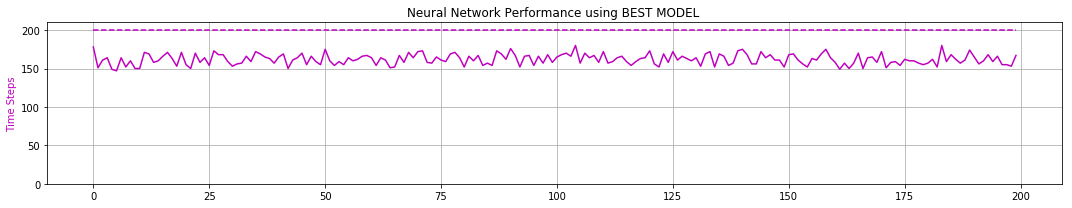

peak memory: 12482.86 MiB, increment: 10892.81 MiB
0 -max- [ 0.203  1.173  0.207  2.008  0.274]
0 -min- [-2.400 -2.641 -0.209 -1.931  0.225]

1 -max- [ 0.295  1.008  0.204  1.848  0.324]
1 -min- [-2.399 -2.938 -0.209 -1.716  0.275]

2 -max- [ 0.171  1.325  0.206  1.834  0.374]
2 -min- [-2.400 -2.834 -0.208 -2.142  0.326]

3 -max- [ 0.317  1.151  0.203  2.141  0.424]
3 -min- [-2.400 -2.767 -0.209 -1.769  0.375]

4 -max- [ 0.228  1.368  0.207  2.001  0.475]
4 -min- [-2.400 -2.633 -0.209 -1.837  0.426]

5 -max- [ 0.184  1.159  0.209  1.965  0.525]
5 -min- [-2.400 -2.419 -0.209 -1.879  0.475]

6 -max- [ 0.373  1.214  0.208  1.745  0.575]
6 -min- [-2.399 -2.624 -0.209 -1.959  0.525]

7 -max- [ 0.229  1.024  0.208  1.745  0.625]
7 -min- [-2.398 -2.645 -0.209 -2.003  0.575]

8 -max- [ 0.314  1.021  0.209  1.825  0.675]
8 -min- [-2.400 -2.407 -0.209 -1.943  0.625]

9 -max- [ 0.316  1.361  0.209  1.925  0.724]
9 -min- [-2.400 -2.612 -0.209 -2.609  0.675]

Quantization TIME:  0.11 minutes


ITER

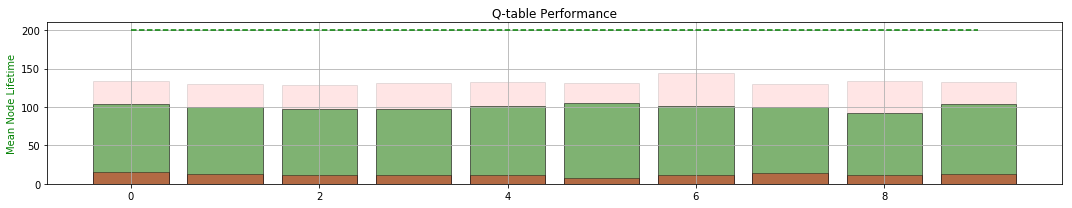

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 104.431	LOSS : 88.508	LOSS : 99.512	LOSS : 92.725	LOSS : 104.453	LOSS : 86.559	LOSS : 93.876	LOSS : 84.252	LOSS : 79.429	LOSS : 92.259	LOSS : 76.501	LOSS : 79.127	LOSS : 85.916	LOSS : 85.074	LOSS : 94.310	LOSS : 77.693	LOSS : 88.458	LOSS : 95.197	LOSS : 72.022	LOSS : 88.412	
Validating... MEAN TIME:  158.465
LOSS : 84.508	LOSS : 91.485	LOSS : 86.550	LOSS : 88.825	LOSS : 89.819	LOSS : 90.967	LOSS : 87.721	LOSS : 76.007	LOSS : 78.153	LOSS : 81.796	LOSS : 91.750	LOSS : 77.398	LOSS : 82.780	LOSS : 76.105	LOSS : 93.964	LOSS : 79.287	LOSS : 86.141	LOSS : 90.254	LOSS : 86.070	LOSS : 76.674	
Validating... MEAN TIME:  122.98
LOSS : 90.040	LOSS : 95.399	LOSS : 84.614	LOSS : 91.578	LOSS : 87.583	LOSS : 81.479	LOSS : 83.449	LOSS : 80.363	LOSS : 82.048	LOSS : 77.961	LOSS : 83.055	LOSS : 80.393	LOSS : 88.901	LOSS : 74.958	LOSS : 87.258	LOSS : 98.159	LOSS : 79.426	LOSS : 82.336	LOSS : 97.420	LOSS : 83.616	
Valid

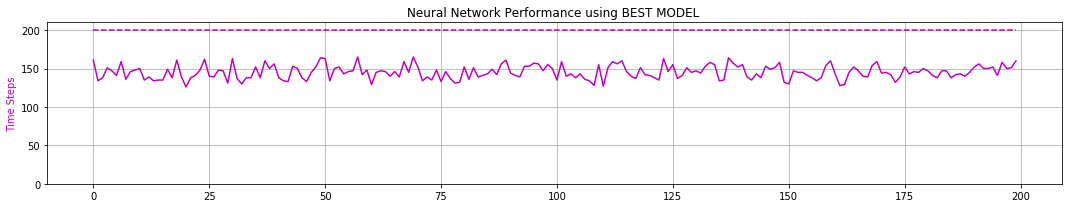

peak memory: 12276.32 MiB, increment: 10668.02 MiB
0 -max- [ 0.185  1.171  0.126  1.482  0.274]
0 -min- [-2.400 -2.608 -0.209 -1.983  0.226]

1 -max- [ 0.210  1.158  0.089  1.472  0.325]
1 -min- [-2.400 -2.650 -0.209 -1.725  0.276]

2 -max- [ 0.187  1.158  0.081  1.209  0.375]
2 -min- [-2.400 -2.592 -0.208 -1.989  0.326]

3 -max- [ 0.206  0.941  0.050  1.241  0.425]
3 -min- [-2.400 -2.596 -0.209 -1.465  0.375]

4 -max- [ 0.221  0.989  0.110  1.459  0.474]
4 -min- [-2.400 -2.822 -0.209 -1.545  0.425]

5 -max- [ 0.197  1.400  0.097  1.268  0.524]
5 -min- [-2.400 -2.452 -0.209 -2.219  0.475]

6 -max- [ 0.194  1.020  0.193  1.416  0.574]
6 -min- [-2.400 -2.423 -0.209 -1.622  0.525]

7 -max- [ 0.182  1.018  0.061  1.455  0.625]
7 -min- [-2.399 -2.642 -0.209 -1.473  0.575]

8 -max- [ 0.185  1.124  0.127  1.176  0.675]
8 -min- [-2.399 -2.409 -0.209 -1.724  0.625]

9 -max- [ 0.210  1.326  0.094  1.592  0.724]
9 -min- [-2.400 -2.571 -0.209 -2.000  0.675]

Quantization TIME:  0.11 minutes


ITER

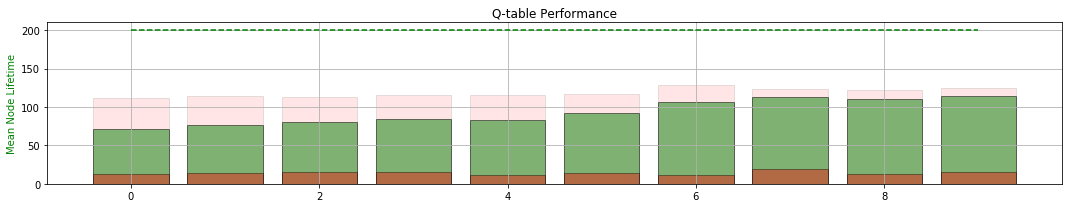

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 104.186	LOSS : 88.792	LOSS : 98.730	LOSS : 100.068	LOSS : 103.575	LOSS : 85.701	LOSS : 89.930	LOSS : 92.913	LOSS : 84.721	LOSS : 87.796	LOSS : 80.541	LOSS : 93.570	LOSS : 91.329	LOSS : 96.171	LOSS : 94.880	LOSS : 90.747	LOSS : 95.549	LOSS : 100.860	LOSS : 100.926	LOSS : 92.330	
Validating... MEAN TIME:  121.545
LOSS : 97.914	LOSS : 86.817	LOSS : 96.961	LOSS : 88.737	LOSS : 100.449	LOSS : 94.924	LOSS : 98.711	LOSS : 92.664	LOSS : 102.911	LOSS : 80.412	LOSS : 89.592	LOSS : 86.237	LOSS : 93.318	LOSS : 95.559	LOSS : 95.917	LOSS : 96.025	LOSS : 89.321	LOSS : 95.199	LOSS : 87.505	LOSS : 92.753	
Validating... MEAN TIME:  132.5
LOSS : 82.466	LOSS : 96.694	LOSS : 90.232	LOSS : 95.958	LOSS : 85.180	LOSS : 86.855	LOSS : 84.339	LOSS : 99.577	LOSS : 88.039	LOSS : 85.695	LOSS : 93.141	LOSS : 83.823	LOSS : 92.033	LOSS : 89.047	LOSS : 97.658	LOSS : 90.460	LOSS : 93.662	LOSS : 81.823	LOSS : 102.836	LOSS : 88.375	


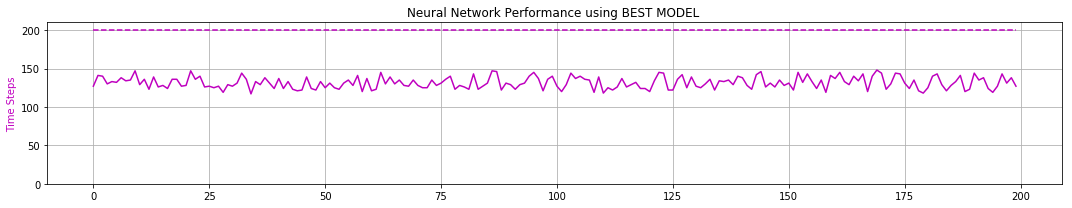

peak memory: 12305.16 MiB, increment: 10684.00 MiB
0 -max- [ 0.192  0.953  0.050  0.915  0.274]
0 -min- [-2.398 -2.419 -0.209 -1.461  0.225]

1 -max- [ 0.200  1.172  0.049  0.905  0.323]
1 -min- [-2.400 -2.397 -0.209 -1.648  0.275]

2 -max- [ 0.218  1.200  0.048  0.934  0.375]
2 -min- [-2.400 -2.396 -0.209 -1.650  0.326]

3 -max- [ 0.207  0.963  0.048  0.861  0.424]
3 -min- [-2.400 -2.236 -0.209 -1.409  0.375]

4 -max- [ 0.203  1.170  0.046  0.907  0.475]
4 -min- [-2.400 -2.424 -0.209 -1.665  0.425]

5 -max- [ 0.189  0.828  0.048  0.883  0.525]
5 -min- [-2.400 -2.429 -0.209 -1.215  0.475]

6 -max- [ 0.197  1.031  0.049  0.949  0.575]
6 -min- [-2.400 -2.366 -0.209 -1.605  0.525]

7 -max- [ 0.186  0.989  0.049  0.869  0.625]
7 -min- [-2.400 -2.207 -0.207 -1.381  0.575]

8 -max- [ 0.208  0.998  0.049  0.959  0.674]
8 -min- [-2.400 -2.218 -0.208 -1.372  0.625]

9 -max- [ 0.197  0.940  0.054  0.921  0.724]
9 -min- [-2.400 -2.164 -0.205 -1.364  0.675]

Quantization TIME:  0.11 minutes


ITER

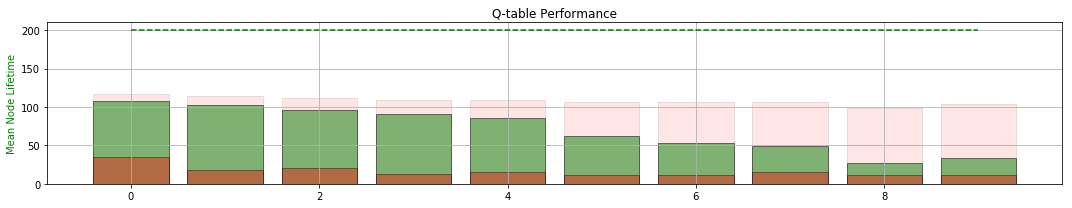

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 94.988	LOSS : 103.468	LOSS : 91.218	LOSS : 99.507	LOSS : 104.567	LOSS : 104.047	LOSS : 110.305	LOSS : 100.895	LOSS : 95.198	LOSS : 104.872	LOSS : 94.484	LOSS : 96.857	LOSS : 108.239	LOSS : 91.456	LOSS : 98.056	LOSS : 119.744	LOSS : 100.952	LOSS : 112.904	LOSS : 97.718	LOSS : 112.922	
Validating... MEAN TIME:  106.93
LOSS : 101.727	LOSS : 98.624	LOSS : 92.539	LOSS : 99.283	LOSS : 92.881	LOSS : 112.666	LOSS : 103.755	LOSS : 103.277	LOSS : 103.030	LOSS : 95.163	LOSS : 94.650	LOSS : 92.868	LOSS : 99.958	LOSS : 104.399	LOSS : 101.357	LOSS : 95.020	LOSS : 98.758	LOSS : 99.617	LOSS : 99.583	LOSS : 107.838	
Validating... MEAN TIME:  173.105
LOSS : 104.541	LOSS : 103.237	LOSS : 108.258	LOSS : 102.650	LOSS : 120.789	LOSS : 101.640	LOSS : 104.385	LOSS : 104.125	LOSS : 98.496	LOSS : 92.670	LOSS : 110.176	LOSS : 106.968	LOSS : 102.192	LOSS : 100.085	LOSS : 109.334	LOSS : 101.843	LOSS : 104.010	LOSS : 110.881	L

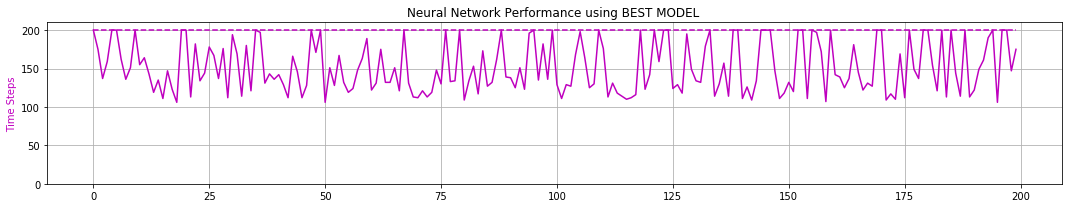

peak memory: 12395.26 MiB, increment: 10773.86 MiB
0 -max- [ 0.185  0.972  0.053  0.967  0.275]
0 -min- [-2.400 -2.410 -0.206 -1.405  0.226]

1 -max- [ 0.210  1.200  0.063  1.252  0.325]
1 -min- [-2.400 -2.605 -0.209 -1.650  0.276]

2 -max- [ 0.200  0.829  0.048  0.957  0.375]
2 -min- [-2.400 -2.423 -0.209 -1.269  0.326]

3 -max- [ 0.198  1.206  0.052  1.008  0.424]
3 -min- [-2.399 -2.451 -0.209 -1.658  0.376]

4 -max- [ 0.189  1.026  0.048  0.929  0.475]
4 -min- [-2.399 -2.435 -0.209 -1.539  0.426]

5 -max- [ 0.200  1.400  0.049  0.950  0.524]
5 -min- [-2.399 -2.431 -0.209 -1.973  0.476]

6 -max- [ 0.192  1.399  0.049  0.838  0.574]
6 -min- [-2.400 -2.262 -0.209 -1.972  0.525]

7 -max- [ 0.217  1.193  0.049  1.011  0.625]
7 -min- [-2.400 -2.578 -0.209 -1.672  0.575]

8 -max- [ 0.207  1.215  0.062  0.909  0.674]
8 -min- [-2.395 -2.440 -0.209 -1.677  0.625]

9 -max- [ 0.219  1.214  0.055  0.885  0.722]
9 -min- [-2.395 -2.444 -0.209 -1.683  0.676]

Quantization TIME:  0.11 minutes


ITER

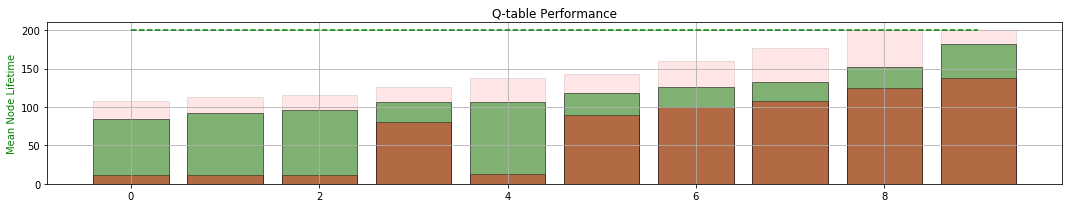

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 84.966	LOSS : 101.253	LOSS : 91.197	LOSS : 101.029	LOSS : 87.713	LOSS : 96.760	LOSS : 94.811	LOSS : 95.057	LOSS : 101.353	LOSS : 83.669	LOSS : 88.145	LOSS : 91.638	LOSS : 83.082	LOSS : 95.268	LOSS : 87.084	LOSS : 94.219	LOSS : 80.836	LOSS : 91.653	LOSS : 92.315	LOSS : 93.499	
Validating... MEAN TIME:  100.035
LOSS : 101.052	LOSS : 95.490	LOSS : 95.037	LOSS : 98.620	LOSS : 96.961	LOSS : 91.420	LOSS : 96.782	LOSS : 91.952	LOSS : 85.540	LOSS : 86.628	LOSS : 93.227	LOSS : 84.105	LOSS : 89.425	LOSS : 91.201	LOSS : 86.508	LOSS : 84.337	LOSS : 83.999	LOSS : 94.400	LOSS : 87.778	LOSS : 82.265	
Validating... MEAN TIME:  200.0
LOSS : 92.524	LOSS : 88.102	LOSS : 89.832	LOSS : 92.131	LOSS : 85.533	LOSS : 74.189	LOSS : 81.440	LOSS : 93.594	LOSS : 87.507	LOSS : 93.643	LOSS : 84.164	LOSS : 90.437	LOSS : 76.839	LOSS : 85.741	LOSS : 87.447	LOSS : 77.868	LOSS : 78.470	LOSS : 93.509	LOSS : 88.838	LOSS : 84.418	
Vali

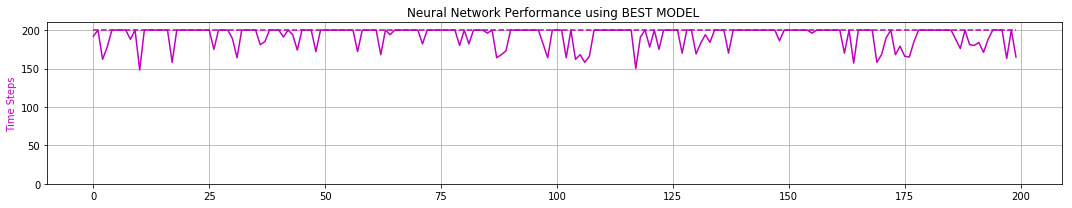

peak memory: 12512.74 MiB, increment: 10862.45 MiB
0 -max- [ 0.216  1.400  0.066  1.627  0.275]
0 -min- [-2.399 -3.490 -0.209 -1.991  0.226]

1 -max- [ 0.178  1.369  0.065  1.855  0.325]
1 -min- [-2.399 -3.529 -0.209 -1.993  0.275]

2 -max- [ 0.186  1.403  0.088  1.635  0.375]
2 -min- [-2.400 -3.396 -0.209 -1.987  0.327]

3 -max- [ 0.182  1.207  0.081  1.937  0.425]
3 -min- [-2.399 -3.681 -0.209 -1.742  0.375]

4 -max- [ 0.174  1.175  0.070  1.886  0.475]
4 -min- [-2.400 -3.552 -0.209 -1.673  0.425]

5 -max- [ 0.153  1.184  0.095  1.852  0.525]
5 -min- [-2.400 -3.405 -0.209 -1.662  0.475]

6 -max- [ 0.146  0.998  0.057  1.878  0.574]
6 -min- [-2.399 -3.406 -0.209 -1.375  0.525]

7 -max- [ 0.120  0.939  0.061  1.633  0.625]
7 -min- [-2.398 -3.196 -0.209 -1.723  0.575]

8 -max- [ 0.152  0.639  0.048  1.595  0.674]
8 -min- [-2.398 -3.147 -0.209 -1.098  0.625]

9 -max- [ 0.499  0.635  0.051  1.537  0.723]
9 -min- [-2.395 -2.993 -0.209 -1.122  0.675]

Quantization TIME:  0.11 minutes


ITER

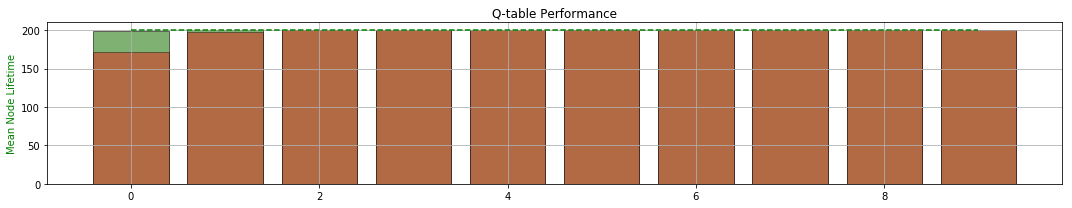

In [20]:
while iteration < MAX_NO_OF_ITERATIONS:

    print("\n")
    print("ITERATION #", iteration)
    tic = datetime.now()
    
    # MAP GYM ENVIRONMENT TO EACH PROCESS IN THE POOL
    ##################################################################
    q_table_list = [node_q_table]* NO_OF_NODES
    iter_list = [iteration] * NO_OF_NODES
    arg_list = [arg for arg in zip(range(NO_OF_NODES), node_boundaries, iter_list, q_table_list)]
    result   = pool.starmap(mp_node_run, arg_list)
    ##################################################################
    
    # GATHER RESULTS
    ##################################################################
    node_boundaries = np.array([item[2] for item in result])
    node_time_rec   = np.array([item[1] for item in result])
    node_exp        = np.array([item[0] for item in result])
    
    all_exp         = np.array([item for each_node_exp in node_exp 
                                    for episode_exp in each_node_exp 
                                    for item in episode_exp]).reshape(-1,N_STATES*2+2)
    total_parallel_timesteps += node_time_rec.max()
    total_serial_timesteps   += node_time_rec.sum()
    EXP_GEN = node_time_rec.sum().astype(int)
    
    print("TOTAL EXPERIENCE GENERATED:   {:d}".format(EXP_GEN.astype(int)))

    print("SMALLEST TIMESTEP: {:d}".format(node_time_rec.min().astype(int)))
    print("LARGEST  TIMESTEP: {:d}".format(node_time_rec.max().astype(int)))

    print("TOTAL SERIAL TIMESTEPS:   {:d}".format(total_serial_timesteps.astype(int)))
    print("TOTAL PARALLEL TIMESTEPS: {:d}".format(total_parallel_timesteps.astype(int)))
    ##################################################################

    # PLOT EXPERIENCES
    ##################################################################
    node_avg_time = node_time_rec.mean(axis=1)
    node_std_time = node_time_rec.std(axis=1)
    node_max_time = node_time_rec.max(axis=1)
    node_min_time = node_time_rec.min(axis=1)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    ax2.set_title("Q-table Performance")
    ax2.bar(range(NO_OF_NODES) , node_max_time, alpha = 0.1, color = 'r', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_avg_time, alpha = 0.5, color = 'g', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_min_time, alpha = 0.4, color = 'r', edgecolor = 'black', capsize=7 )

    ax2.plot(np.ones_like(node_avg_time)*200, 'g--')
    ax2.set_ylabel('Mean Node Lifetime',color = 'g')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    ##################################################################
    
    if node_avg_time[node_avg_time >= 195].shape[0] > NO_OF_NODES/2:
        final_result = "SUCCESS"
        break

    # SEGREGATE AND STORE EXPERIENCES
    ##################################################################
    dqn.memory = np.insert(dqn.memory,0,all_exp,0)
    dqn.memory = dqn.memory[:MIN_MEMORY_CAP,:]
    dqn.memory_counter += all_exp.shape[0]
#     good_mem = all_exp[all_exp[:,N_STATES+1] == 1]    
#     bad_mem  = all_exp[all_exp[:,N_STATES+1] < 1]


#     dqn.good_memory = np.insert(dqn.good_memory, 0, good_mem , 0)
#     dqn.good_memory_counter += good_mem.shape[0]

#     dqn.bad_memory  = np.insert(dqn.bad_memory, 0, bad_mem , 0)
#     dqn.bad_memory_counter += bad_mem.shape[0]

#     dqn.good_memory = dqn.good_memory[:MIN_MEMORY_CAP,:]
#     dqn.bad_memory = dqn.bad_memory[:MIN_MEMORY_CAP,:]

    NN_ITERATIONS = MAX_NN_ITERATIONS
    print("MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.memory_counter))

#     print("GOOD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.good_memory_counter))
#     print("BAD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.bad_memory_counter))
    ##################################################################

    # LEARN
    ##################################################################
    print("Training Neural Network for", NN_ITERATIONS, "iterations", "@ LR = ", NN_LR)
    tic=datetime.now()
    nn_level_up_metric = 0
    for nn_iter in range(NN_ITERATIONS):
        dqn.learn()
        #validate by running for TIMESTEP_LIMIT iterations
        if(nn_iter%int(NN_ITERATIONS/5) == int(NN_ITERATIONS/5)-1):
            print("\nValidating... ",end="")
            time_rec = []
            v_env.length   = np.random.uniform(LENGTH_ABS_MIN, LENGTH_ABS_MAX)
            v_xtra = [v_env.length]
            for i_episode in range(TIMESTEP_LIMIT):
                time_step = 0
                s = v_env.reset()
                s = np.append(s, v_xtra)
                while True:
                    time_step += 1 
                    a = dqn.choose_greedy_action(s)
                    s_, r, done, info = v_env.step(a)
                    s_ = np.append(s_, v_xtra)
                    if done:
                        break
                    s = s_
                time_rec = np.append(time_rec, time_step)
            mean_time = time_rec.mean()
            print("MEAN TIME: ", mean_time)
            if mean_time >= nn_level_up_metric:
                nn_level_up_metric = mean_time
                nn_level_up_metric = clamp(0, nn_level_up_metric, 195)
                torch.save(dqn.eval_net.state_dict(), MODEL_FILENAME)

    print("TRAINING TIME:{}".format(datetime.now()-tic))
    ##################################################################

    # CHECK PERFORMANCE OF THE BEST MODEL
    ##################################################################
    best_dqn = D3QN()
    best_dqn.eval_net.load_state_dict(torch.load(MODEL_FILENAME))
    best_dqn.eval_net.eval()

    time_rec = []
    for i_episode in range(TIMESTEP_LIMIT):
        env.length   = np.random.uniform(LENGTH_ABS_MIN, LENGTH_ABS_MAX)
        Xtra = [env.length]
        time_step = 0
        s = env.reset()
        s = np.append(s, Xtra)

        while True:
    #         env.render()
            time_step += 1 
            a = best_dqn.choose_greedy_action(s)
            s_, r, done, info = env.step(a)
            s_ = np.append(s_, Xtra)

            if done:
                break
            s = s_
        time_rec = np.append(time_rec, time_step)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    data = time_rec
    ax2.plot(data, color = 'm')
    ax2.plot(np.ones_like(data)*200, 'm--')
    ax2.set_title('Neural Network Performance using BEST MODEL ')
    ax2.set_ylabel('Time Steps',color = 'm')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    
    
        
    ##################################################################
    
    # CREATE ONE LARGE Q-TABLES FROM WHICH THE NODES STRIP
    ##################################################################
        
#     node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
#                                         [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
#                                         [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN * NO_OF_NODES  ])
    
    start = timeit.default_timer()
    # GET Q-VALUES 
    %memit node_q_table = best_dqn.get_greedy_action(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN, LO_GRAIN*NO_OF_NODES).astype(np.intp)

    # SAVE QFILE
#     np.save(node_QFILE, node_q_table)
    stop = timeit.default_timer()

#     ##################################################################
    
#     # CREATE INDIVIDUALIZED Q-TABLES FOR THE NODES
#     ##################################################################
    
    for node_id in range(NO_OF_NODES):
# #         # SET STATE VALUE BORDERS AS REQUESTED BY THE NODE
# #         ###############################################
#         [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
#          C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]  = node_boundaries[node_id]
# #         ###############################################
        print(node_id,'-max-',node_boundaries[node_id][:N_STATES])
        print(node_id,'-min-',node_boundaries[node_id][N_STATES:])
        print("")
        
# #         node_boundaries[node_id] = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_MAX,
# #                                     C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_MIN]
# #         # CREATE STATE COMBINATIONS
# #         ###############################################

#     node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
#                                         [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
#                                         [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN   ])
#         ###############################################
#     start = timeit.default_timer()
#     # GET Q-VALUES 
#     %memit node_q_table = best_dqn.get_qvals(node_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN , -1).astype(np.float16)

#     # SAVE QFILE
#     np.save(node_QFILE, node_q_table)
#         #############################################################################################################################################
#     stop = timeit.default_timer()
    print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    iteration += 1
pool.close()
pool.join()

In [21]:
print("Total Parallel Timesteps : ", total_parallel_timesteps)
print("Total Serial Timesteps   : ", total_serial_timesteps)
print("Speed-up                 :  {:6.2f}".format(total_serial_timesteps/total_parallel_timesteps))

Total Parallel Timesteps :  1137.0
Total Serial Timesteps   :  746873.0
Speed-up                 :  656.88


In [22]:
pool.close()
pool.join()
if iteration == MAX_NO_OF_ITERATIONS:
    final_result = "FAILURE"

In [23]:
print("{:6d} {} {:3d} {:3d} {:7d} {:10d} {:10.2f}".format(seed, final_result, int(node_min_time.min()), int(iteration), int(total_parallel_timesteps), int(total_serial_timesteps), total_serial_timesteps/total_parallel_timesteps))

  9295 SUCCESS 171   6    1137     746873     656.88
